In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [2]:
def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x + np.random.normal(loc=0, scale=scale, size=x.shape)
    gaussian_data_x = np.clip(gaussian_data_x, 0, 1)

    # gaussian_data_x = torch.tensor(gaussian_data_x)
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
    return gaussian_data_x

In [3]:
training_data = MNIST(root="../input/", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="../input/", train=False, download=True, transform=ToTensor())

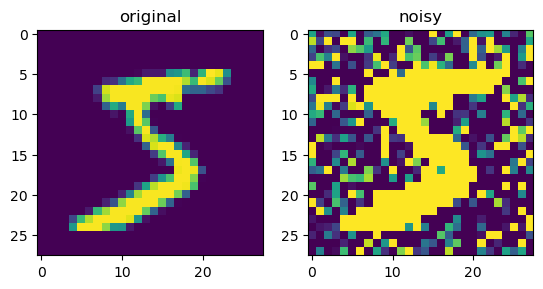

In [4]:
img = training_data.data[0]
gaussian = gaussian_noise(img)

plt.subplot(1, 2, 1)
plt.title("original")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("noisy")
plt.imshow(gaussian)

plt.show()

# 학습용 데이터 만들기

In [5]:
from torch.utils.data.dataset import Dataset

In [6]:
class Denoising(Dataset):
    def __init__(self):
        self.mnist = MNIST(
            root="../input/", train=True, download=True, transform=ToTensor()
        )
        self.data = []  # 노이즈가 낀 데이터 담는 리스트

        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i])
            # input_tensor = torch.tensor(noisy_input)
            self.data.append(torch.unsqueeze(noisy_input, dim=0))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        data = self.data[i]
        label = self.mnist.data[i] / 255
        return data, label

# 인코더 모델 정의하기

In [7]:
import torch.nn as nn

In [8]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
        self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x

# 디코더 모델 정의하기

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(
            in_channels=8, out_channels=8, kernel_size=2, stride=2
        )
        self.upsample2 = nn.ConvTranspose2d(
            in_channels=16, out_channels=16, kernel_size=2, stride=2
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)

        return x

# CAE 모델 정의하기

In [11]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)

        return x

# 모델 학습하기

In [12]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
trainset = Denoising()
train_loader = DataLoader(trainset, batch_size=32)

In [15]:
model = CAE().to(device)
model

CAE(
  (enc): Encoder(
    (conv1): BasicBlock(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (conv2): BasicBlock(
      (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (dec): Decoder(
    (conv1): BasicBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (conv2): BasicBlock(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (conv3): Conv2d(16, 1, kernel_size=(3, 3), str

In [16]:
lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)

In [17]:
for epoch in range(20):
    iterator = tqdm.tqdm(train_loader)

    for data, label in iterator:
        optim.zero_grad()

        pred = model(data.to(device))

        loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch {epoch + 1} loss: {loss.item()}")

epoch 20 loss: 0.00819549523293972: 100%|█████████████████████████████████████████| 1875/1875 [00:13<00:00, 143.83it/s]


In [18]:
torch.save(model.state_dict(), "./CAE.pth")

# 모델 성능 평가하기

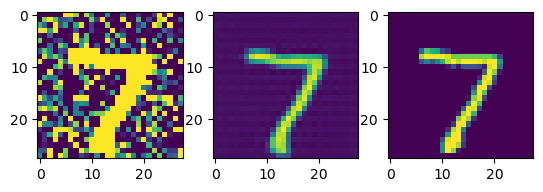

In [19]:
model.cpu()
with torch.no_grad():
    model.load_state_dict(
        torch.load("./CAE.pth", weights_only=True, map_location=device)
    )

    img = test_data.data[0]
    gaussian = gaussian_noise(img)

    # 모델의 입력 모양에 맞춰 채널 차원 추가
    input_tensor = torch.unsqueeze(gaussian, dim=0)
    input_tensor.type(torch.FloatTensor)
    input_tensor.to(device)
    # 배치 크기 1을 위한 배치 차원 추가
    input_tensor = torch.unsqueeze(input_tensor, dim=0)

    plt.subplot(1, 3, 1)
    plt.imshow(torch.squeeze(gaussian))
    plt.subplot(1, 3, 2)
    plt.imshow(torch.squeeze(model(input_tensor)))
    plt.subplot(1, 3, 3)
    plt.imshow(torch.squeeze(img))
    plt.show()